## **Download Dataset**

In [5]:
!pip install kaggle

In [6]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"amirhosseinfeiz","key":"5228cdd8a111ac93b8ddde7d70369a5f"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d kmader/mias-mammography

 99% 309M/312M [00:02<00:00, 159MB/s]
100% 312M/312M [00:02<00:00, 132MB/s]


In [9]:
!unzip 'mias-mammography'

Archive:  mias-mammography.zip
  inflating: Info.txt                
  inflating: all-mias.tar.gz         
  inflating: all-mias/Info.txt       
  inflating: all-mias/Licence.txt    
  inflating: all-mias/README         
  inflating: all-mias/mdb001.pgm     
  inflating: all-mias/mdb002.pgm     
  inflating: all-mias/mdb003.pgm     
  inflating: all-mias/mdb004.pgm     
  inflating: all-mias/mdb005.pgm     
  inflating: all-mias/mdb006.pgm     
  inflating: all-mias/mdb007.pgm     
  inflating: all-mias/mdb008.pgm     
  inflating: all-mias/mdb009.pgm     
  inflating: all-mias/mdb010.pgm     
  inflating: all-mias/mdb011.pgm     
  inflating: all-mias/mdb012.pgm     
  inflating: all-mias/mdb013.pgm     
  inflating: all-mias/mdb014.pgm     
  inflating: all-mias/mdb015.pgm     
  inflating: all-mias/mdb016.pgm     
  inflating: all-mias/mdb017.pgm     
  inflating: all-mias/mdb018.pgm     
  inflating: all-mias/mdb019.pgm     
  inflating: all-mias/mdb020.pgm     
  inflating: all-mi

In [10]:
# Find the direction of dataset
'''import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

"import numpy as np\nimport pandas as pd\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

In [11]:
import cv2
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
from keras import optimizers
from keras import losses
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random # for visualization
print('Libraries Imported')

Libraries Imported


In [12]:
path = 'all-mias/'

an example of image path

../input/mias-mammography/all-mias/mdb001.pgm

## Read Data

In [13]:
import pandas as pd

print("reading dataframe")
info=pd.read_csv("Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)

reading dataframe


In [14]:
info

,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,mdb003,D,NORM,NaN,NaN,NaN,NaN
3,mdb004,D,NORM,NaN,NaN,NaN,NaN
4,mdb005,F,CIRC,B,477.0,133.0,30.0
...,...,...,...,...,...,...,...
325,mdb318,D,NORM,NaN,NaN,NaN,NaN
326,mdb319,D,NORM,NaN,NaN,NaN,NaN
327,mdb320,D,NORM,NaN,NaN,NaN,NaN
328,mdb321,D,NORM,NaN,NaN,NaN,NaN


In [15]:
info.dropna(subset = ["SEVERITY"], inplace=True)

info.reset_index(inplace = True)
info

,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,5,mdb005,F,CIRC,B,500.0,168.0,26.0
4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
...,...,...,...,...,...,...,...,...
118,281,mdb274,F,MISC,M,127.0,505.0,123.0
119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
120,319,mdb312,F,MISC,B,240.0,263.0,20.0
121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [16]:
info = info.drop([3], axis=0)
info.reset_index(inplace = True)
info

,level_0,index,REFNUM,BG,CLASS,SEVERITY,X,Y,RADIUS
0,0,0,mdb001,G,CIRC,B,535.0,425.0,197.0
1,1,1,mdb002,G,CIRC,B,522.0,280.0,69.0
2,2,4,mdb005,F,CIRC,B,477.0,133.0,30.0
3,4,10,mdb010,F,CIRC,B,525.0,425.0,33.0
4,5,12,mdb012,F,CIRC,B,471.0,458.0,40.0
...,...,...,...,...,...,...,...,...,...
117,118,281,mdb274,F,MISC,M,127.0,505.0,123.0
118,119,297,mdb290,D,CIRC,B,337.0,353.0,45.0
119,120,319,mdb312,F,MISC,B,240.0,263.0,20.0
120,121,321,mdb314,F,MISC,B,518.0,191.0,39.0


In [17]:
# taking the images filenames in to dictionary
ids = {}
for i in range(len(info)):
    ids[i] = info.REFNUM[i]
#ids

## Turning our outputs B-M to 1-0

In [18]:
import numpy as np

# Turning our outputs B-M to 1-0
label = []
for i in range(len(info)):
    if info.SEVERITY[i] == 'B':
        label.append(1)
    else:
        label.append(0)

In [19]:
label = np.array(label)

In [20]:
label.shape

(122,)

In [21]:
# define the every images filepaths in to list
img_name = []

for i in range(len(label)):
        img_name.append(path + info.REFNUM[i]+ '.pgm')

In [22]:
img_name = np.array(img_name)

In [23]:
#print(img_name)
print(f'image addres amount {img_name.shape}')

image addres amount (122,)


In [35]:
def remove_text(image):
    ret,thresh1 = cv2.threshold(image,20,255,cv2.THRESH_BINARY)
    
    kernel = np.ones((20,20),np.uint8)
    opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    
    kernel = np.ones((500,400),np.uint8)
    erosion = cv2.erode(opening,kernel,iterations = 1)
    
    kernel = np.ones((800,800),np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 1)
    
    kernel = np.ones((500,300),np.uint8)
    erosion = cv2.erode(dilation,kernel,iterations = 1)

    kernel = np.ones((400,50),np.uint8)
    dilation = cv2.dilate(erosion,kernel,iterations = 1)
    
    merged = cv2.bitwise_and(image, image , mask=dilation)
    return merged

<class 'numpy.ndarray'>


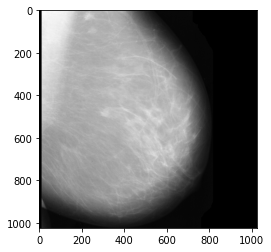

In [126]:
from PIL import Image

images = cv2.imread(img_name[50], 0)
#images = crop_image(img_name[50])
#image = Image.fromarray(images)
text_removed_images = remove_text(images)
print(type(text_removed_images))
#img = cv2.imread(text_removed_images)
plt.imshow(text_removed_images, 'gray')

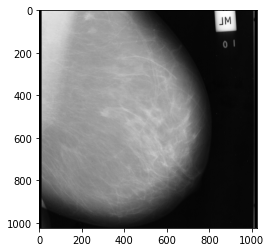

In [127]:
plt.imshow(images,'gray')

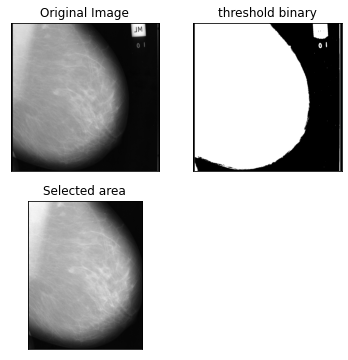

In [135]:
images = crop_image(img_name[50])

In [133]:
type(images)

function

In [64]:
bold_start = '\033[1m'
bold_end   = '\033[0m'

print(bold_start, "Hello" , "World", bold_end)

 Hello World 


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab as pylab
from skimage import io
from skimage import color
import cv2
import copy
from PIL import Image

In [69]:
def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])
    
    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)
    
    return image

def read_image(filename):
    image = cv2.imread(filename,0)
    image = color.rgb2gray(image)
    image = right_orient_mammogram(image)
    return image


def crop_image(IMG_IN):
  
  original = read_image(IMG_IN)
  # Read the image, convert it into grayscale, and make in binary image for threshold value of 1.

  img = read_image(IMG_IN)
  # use binary threshold, all pixel that are beyond 3 are made white
  _, thresh_original = cv2.threshold(img, 20, 255, cv2.THRESH_BINARY)

  # Now find contours in it.
  thresh = copy.copy(thresh_original)
  contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

  # get contours with highest height
  lst_contours = []
  for cnt in contours:
      ctr = cv2.boundingRect(cnt)
      lst_contours.append(ctr)
  x,y,w,h = sorted(lst_contours, key=lambda coef: coef[3])[-1]


  # draw contours
  ctr = copy.copy(original)
  cv2.rectangle(ctr, (x,y),(x+w,y+h),(0,255,0),2)

  crop_img = ctr[y:y+h, x:x+w]

  crop_img = remove_text(crop_img)
  # display results with matplotlib

  print('==============================================================================================')

  bold_start = '\033[1m'
  bold_end   = '\033[0m'

  print(bold_start, "The output of the cropped image", bold_end)

  plt.figure(figsize=(12,12))
  # original
  #original = original[:,:,::-1] # flip color for maptolib display
  plt.subplot(131), plt.imshow(original, 'gray')
  plt.title('Original Image'), plt.xticks([]),plt.yticks([])

  # Threshold
  plt.subplot(132), plt.imshow(thresh_original, cmap='gray')
  plt.title('threshold binary'), plt.xticks([]),plt.yticks([])

  # selected area for future crop
  #ctr = ctr[:,:,::-1] # flip color for maptolib display
  plt.subplot(133), plt.imshow(crop_img, 'gray')
  plt.title('Selected area'), plt.xticks([]),plt.yticks([])

  plt.show()

  print('==============================================================================================')

  bold_start = '\033[1m'
  bold_end   = '\033[0m'

  print(bold_start, "The output of the ADAPRIVE HISTOGRAM EQULIZATION", bold_end)

  img_raw = LoadImageFloat(crop_img, bits = 16)
  img_plain = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                      , adaptive_eq_args = None)
  img_adaptive = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                      , adaptive_eq_args = dict(clip_limit = 0.02))
  
  ImageComparison([img_raw, img_plain, img_adaptive], dpi = 200 \
                , show_histogram = True)

 The output of the cropped image 


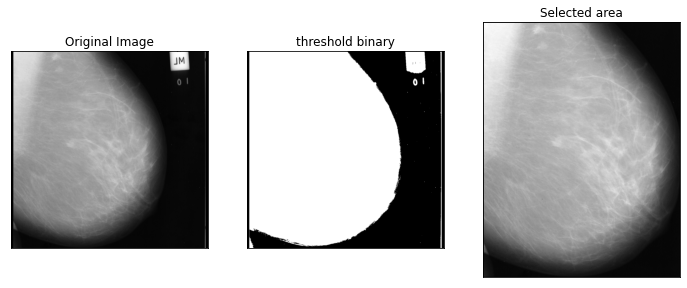

 The output of the ADAPRIVE HISTOGRAM EQULIZATION 


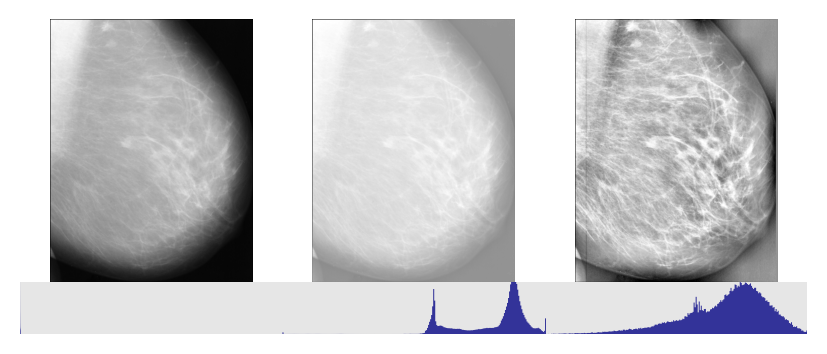

In [70]:
i = crop_image(img_name[50])

In [50]:
type(i)

list

In [26]:
# view image random images
def view_25_random_image():
    for i in range(25):
        rand = random.randint(0,len(label)-1)
    
        img = crop_image(img_name[rand])

random_images = view_25_random_image()

NameError: ignored

In [44]:
import numpy as NP
import pandas as PD
import scipy.ndimage as NDI
import matplotlib as MP
import matplotlib.pyplot as MPP

import skimage as SKI
from skimage import io as SKIO
# import cv2 as CV

%matplotlib inline

def LoadImageFloat(filename, bits = 0):
    # image loading with bit conversion
    img = filename / 2**bits

    ## alternative:
    # img = SKI.img_as_float(SKIO.imread(filename)) / 2**bits

    return img

### remove axis labels from a matplotlib axis
def FullDespine(ax):

    ax.get_xaxis().set_tick_params(which='none')
    ax.get_yaxis().set_tick_params(which='none')
    ax.get_xaxis().set_tick_params(which='both', direction='out')
    ax.get_yaxis().set_tick_params(which='both', direction='out')

    ax.tick_params(top=False)
    ax.tick_params(right=False)
    ax.tick_params(left=False)
    ax.tick_params(right=False)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

def ConvertBits12to16(file_in, file_out):
    img = MPP.imread(file_in) / 2**12
    img = NP.array((img)*(2**16), dtype = NP.uint16)
    SKIO.imsave(file_out, img)

In [38]:
def ImageComparison(  image_list, n_cols = 4, dpi = 300, plot_args = dict(cmap = 'gray') \
                    , show_histogram = False, titles = None):
    ### plot multiple images side by side

    ## layout
    n_rows = (len(image_list)-1) // n_cols + 1
    n_cols = NP.min([len(image_list), n_cols])
    height_ratios = [1, 0.2]*n_rows if show_histogram else [1]*n_rows
    width_ratios = [1]*n_cols

    ## figure preparation
    cm = 1/2.54 # inch to cm conversion
    figwidth = 10 * cm
    fig = MPP.figure(  dpi = dpi \
                     , figsize = (figwidth, figwidth * NP.sum(height_ratios) / NP.sum(width_ratios) ) \
                     , facecolor = 'w')
    fig.subplots_adjust( \
                          top    = 1. \
                        , right  = 1. \
                        , bottom = 0. \
                        , left   = 0. \
                        , wspace = 0.00 # column spacing \
                        , hspace = 0.00 # row spacing \
                        )

    ## grid of images
    grid = MP.gridspec.GridSpec( \
                              n_rows * (2 if show_histogram else 1) \
                            , n_cols \
                            , height_ratios = height_ratios \
                            , width_ratios = width_ratios \
                            )

    ## plot images:
    for grid_idx, img in enumerate(image_list):
        col = (grid_idx) % n_cols
        row = (grid_idx // n_cols) * (2 if show_histogram else 1)

        ax = fig.add_subplot(grid[row, col], aspect = 'equal')

        ax.imshow(img, **plot_args)

        FullDespine(ax)

        if titles is not None:
            ax.set_title(titles[grid_idx], fontsize = 8)

        if show_histogram:
            # optionally show the histogram below the image
            ax = fig.add_subplot(grid[row+1, col], frameon=True, facecolor = (0.9,0.9,0.9))
            heights, _, _ = ax.hist(  img.ravel(), bins = 2**8 \
                                    , histtype='stepfilled', color= (0.2, 0.2, 0.6) \
                                    , density = True \
                                   )
            ax.set_ylim(NP.percentile(heights, [0, 98])*1.05)

            ax.set_xlim([0., 1.])
            FullDespine(ax)

    MPP.show();

In [39]:
def Normalize(img):
    ### spread an image histogram over the bit range
    # print (NP.amin(img), NP.amax(img))
    img = img.copy()

    img = img - NP.amin(img) 
    img = img / NP.amax(img)
    # img = img % 1

    return img

def HistogramCut(img, shift = 0., cap = 1.):
    ### restrict the histogram to a rante between 'shift' and 'cap' 
    ## should be between 0. and 1., with shift < cap 
    img = img.copy()
    img[img>cap] = cap

    img -= shift
    img[img<0] = 0.

    img /= (cap-shift)

    return img

In [40]:
def DefaultImageManipulation(img_raw, edge_factor = 0., adaptive_eq_args = None):

    # initial equalization
    img = Normalize(SKI.exposure.adjust_log(img_raw.copy(), gain = 1., inv = False))

    # edge amplification
    blurred_image = NDI.filters.gaussian_filter(img, 32.)
    edges = Normalize(NP.subtract(img, blurred_image))

    img = Normalize(NP.add(img, edge_factor*edges)/(1.+edge_factor))

    # second equalization
    img = Normalize(SKI.exposure.adjust_log(img, gain = 4., inv = False))

    # adaptive equalization
    if adaptive_eq_args is not None:
        img = SKI.exposure.equalize_adapthist( img.copy(), **adaptive_eq_args )

    # another global equalization
    img = SKI.exposure.adjust_log(img, gain = 1., inv = False)

    # cut the histogram
    img = HistogramCut(img, 0.08, 0.98)
    img = HistogramCut(Normalize(img))

    return img

In [53]:
img_raw = LoadImageFloat('mdb001.png', bits = 16)
img_plain = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                     , adaptive_eq_args = None)
img_adaptive = DefaultImageManipulation(img_raw.copy(), edge_factor = 1.0 \
                                     , adaptive_eq_args = dict(clip_limit = 0.02))

<class 'list'>


TypeError: ignored

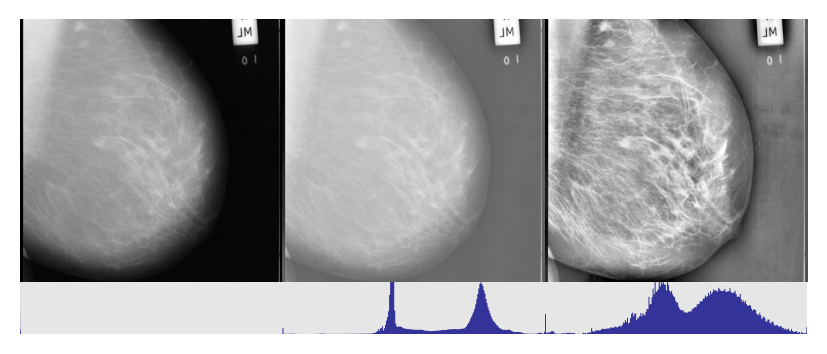

In [33]:
ImageComparison([img_raw, img_plain, img_adaptive], dpi = 200 \
                , show_histogram = True)